<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

work_dir = "./drive/My Drive/CNN/"
if not os.path.exists(work_dir):
  os.makedirs(work_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load("/content/drive/My Drive/CI_FinalProject/Copia di train_img_224.npy")
train_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di train_lab.npy")

print(train_lbls.shape) # 2864 images (it is a quite small dataset)
print(np.count_nonzero(train_lbls)) # 1546 
# 1546 images belong to class 1, this means 1318 images belong to class 0
# so our class distribution is good

# we have to equally distribute otherwise the error:
### Training and validation subsets have different number of classes after the 
### split. If your numpy arrays are sorted by the label, you might want to shuffle them.
# could be raised. This is due to the distribution of classes of the labels.
# for example after the split, the training labels set contains both class 1 and 2,
# and on the other hand validation labels set contains either class 1 or class 2.
# Even if the train data would cointain both the classes it's better to equally 
# distribute the two classes over the sets.
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
del(X_train, X_val)
del(y_train, y_val)

# this is done to transform the gray imgs into rgb images
# X = X.astype('float32')/65536
X = np.stack((X,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_image_224.npy")
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_label.npy")

test_gray_imgs = test_gray_imgs.astype('float32') / 65536

del(test_gray_imgs)

(2864,)
1546


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
#     rotation_range=45, 
#     zoom_range=[1.5, 0], 
    rescale=1./65536, 
#     horizontal_flip=True, vertical_flip=True, 
    validation_split=val_split)

train_iterator = train_datagen.flow(X, y, batch_size=32, subset='training')

validation_iterator = train_datagen.flow(X, y, batch_size=8, subset='validation')
# validation_iterator = train_datagen.flow(train_rgb_imgs, train_lbls, batch_size=16, subset='validation')

test_datagen = ImageDataGenerator(
    rescale=1./65536, 
    horizontal_flip=True, vertical_flip=True)

# test_iterator = test_datagen.flow(test_gray_imgs, test_lbls, batch_size=8)
test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=8)

Using TensorFlow backend.


In [4]:
from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
# LAYER 1
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# # LAYER 4
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# with 1024 seems a lot more stable but start overfitting
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

####

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flat

In [5]:
from keras import optimizers
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
#               optimizer='adam',
              metrics=['acc'])

# model.fit_generator?
history = model.fit_generator(train_iterator, steps_per_epoch=35, epochs=100,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=35)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
35/35 [==============================] - 11s 302ms/step - loss: 0.7075 - acc: 0.5295 - val_loss: 0.7187 - val_acc: 0.4714
Epoch 2/100
35/35 [==============================] - 7s 202ms/step - loss: 0.6874 - acc: 0.5554 - val_loss: 0.6760 - val_acc: 0.5536
Epoch 3/100
35/35 [==============================] - 7s 213ms/step - loss: 0.6705 - acc: 0.6050 - val_loss: 0.7256 - val_acc: 0.5217
Epoch 4/100
35/35 [==============================] - 7s 202ms/step - loss: 0.6508 - acc: 0.6464 - val_loss: 0.6279 - val_acc: 0.7429
Epoch 5/100
35/35 [==============================] - 7s 202ms/step - loss: 0.6364 - acc: 0.6305 - val_loss: 0.6118 - val_acc: 0.6667
Epoch 6/100
35/35 [==============================] - 7s 202ms/step - loss: 0.6213 - acc: 0.6580 - val_loss: 0.7289 - val_acc: 0.5286
Epoch 7/100
35/35 [==============================] - 7s 202ms/step - loss: 0.5887 - acc: 0.6887 - val_loss: 0.6094 - val_acc: 0.6377
Epoch 8/100
35/35 [=

In [0]:
# from keras.models import Sequential, Model
# from keras import layers

# height = 224
# width = 224

# channels = 3

# num_classes = 2

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# # Dende
# # model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# model.save_(os.path.join(work_dir, "ScratchCNN04.h5"))

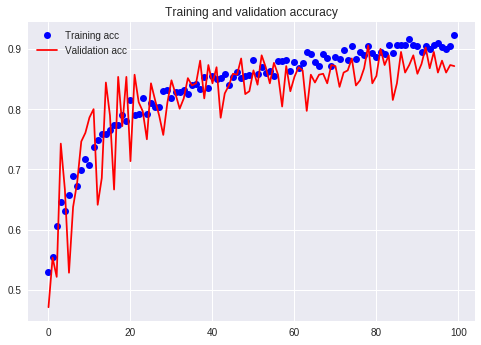

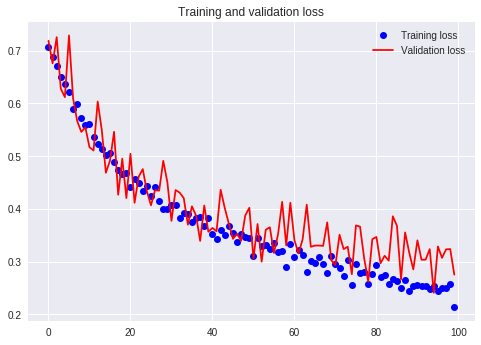

In [8]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

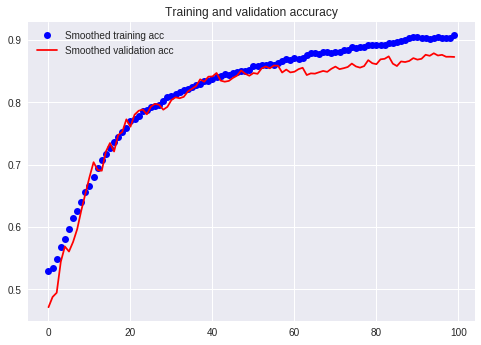

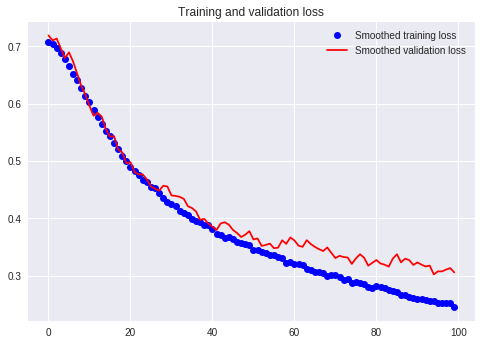

In [9]:
import matplotlib.pyplot as plt


def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
results = model.evaluate_generator(test_iterator, steps=22, verbose=1)

print("test_loss: ", results[0], " test_acc: ", results[1])

22/22 [==============================] - 0s 19ms/step
test_loss:  0.287154440514066  test_acc:  0.8977272727272727


In [0]:
# really slow.... is train set too big?? or steps per epoch too low